Predicting Chronic Kidney Disease in Patients


We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import copy
import random
from sklearn.pipeline import Pipeline

/Users/richardmason/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
with open('chronic_kidney_disease_header.txt') as f:
    content = f.read()

In [3]:
print(content)

1. Title: Early stage of Indians Chronic Kidney Disease(CKD)
2. Source Information:
  (a) Source: 
		Dr.P.Soundarapandian.M.D.,D.M
	     (Senior Consultant Nephrologist), 
		Apollo  Hospitals, 
		Managiri,
		Madurai Main Road, 
		Karaikudi,
		Tamilnadu,
		India.
  (b) Creator: 
		L.Jerlin Rubini(Research Scholar)
		Alagappa University
		EmailId   :jel.jerlin@gmail.com
		ContactNo :+91-9597231281
  (c) Guided by: 
		Dr.P.Eswaran Assistant Professor,
		Department of Computer Science and Engineering,
		Alagappa University,
		Karaikudi,
		Tamilnadu,
		India.
		Emailid:eswaranperumal@gmail.com
  (d) Date     : july 2015
3.Relevant Information:
		age		-	age	
		bp		-	blood pressure
		sg		-	specific gravity
		al		-   	albumin
		su		-	sugar
		rbc		-	red blood cells
		pc		-	pus cell
		pcc		-	pus cell clumps
		ba		-	bacteria
		bgr		-	blood glucose random
		bu		-	blood urea
		sc		-	serum creatinine
		sod		-	sodium
		pot		-	potassium
		hemo		-	hemoglobin
		pcv		-	packed cell volume
		wc		-	white bl

In [4]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [5]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: age, blood pressure, albumin, serum creatinine, sodium, potassium, hyptertension, diabetes, pedal edema

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


In [7]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

# This approach lowers the statistical power because we have fewer datapoints, and of course we are no longer using all the information, because we deleted (in this case) almost half of the data!!

In [11]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [19]:
df.loc[0, 'age']

48.0

In [8]:
df_listwise = df.dropna()

In [9]:
df_listwise.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,ckd


In [10]:
df_listwise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 399
Data columns (total 25 columns):
age      158 non-null float64
bp       158 non-null float64
sg       158 non-null float64
al       158 non-null float64
su       158 non-null float64
rbc      158 non-null object
pc       158 non-null object
pcc      158 non-null object
ba       158 non-null object
bgr      158 non-null float64
bu       158 non-null float64
sc       158 non-null float64
sod      158 non-null float64
pot      158 non-null float64
hemo     158 non-null float64
pcv      158 non-null float64
wbcc     158 non-null float64
rbcc     158 non-null float64
htn      158 non-null object
dm       158 non-null object
cad      158 non-null object
appet    158 non-null object
pe       158 non-null object
ane      158 non-null object
class    158 non-null object
dtypes: float64(14), object(11)
memory usage: 32.1+ KB


### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: It is easy to imagine that a doctor forgot to order some of the tests that would enable us(in this case) to fill in some of this missing data, and likewise that a nurse forgot to perform some ordered procedure, or that the orders for the procedure got otherwise lost somewhere in between the doctor and nurse communication, as the doctor almost certainly did not perform the actual tests from whence this data was acquired.  

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: one that predicts that everyone has CKD

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We minimized type II error: false negatives

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:We aren't actually testing anyone for ckd, and at the expense of many false positives, or lots of people who don't have CKD will be falsely told that they do

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple) model can I create that will accomplish this?

Answer: A model that predicts that everyone does not have CKD

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Here, we are instead minimizing false positives, type I error

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: Again, are aren't actually doing anything.  And further, we will minimize type I error, false positives, at the expense of many false negatives, or lots of people who have ckd will in fact falsely be told that they don't have it.  Very dangerous

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [9]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [10]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [11]:
df['class'] = df['class'].map(lambda x: 1 if x == 'ckd' else 0)

In [12]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1


In [13]:
y = df['class']

In [14]:
df1 = df.copy()

In [15]:
# df.drop(['class'], axis = 1, inplace=True)

In [16]:
df.corr()['class'].sort_values()

hemo    -0.768919
pcv     -0.741427
sg      -0.732163
rbcc    -0.699089
sod     -0.375674
pot      0.084541
age      0.227268
wbcc     0.231919
bp       0.294077
sc       0.299969
su       0.344070
bu       0.380605
bgr      0.419672
al       0.627090
class    1.000000
Name: class, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null int64
dtypes: float64(14), int64(1), object(10)
memory usage: 78.2+ KB


In [21]:
df_no_nulls = df[['hemo', 'bp', 'age', 'class']].dropna()

In [22]:
X = df_no_nulls[['hemo', 'bp', 'age']]
y = df_no_nulls['class']

In [23]:
y.count()

331

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 399
Data columns (total 3 columns):
hemo    331 non-null float64
bp      331 non-null float64
age     331 non-null float64
dtypes: float64(3)
memory usage: 10.3 KB


In [25]:
logreg = LogisticRegression(penalty = 'l1')

In [26]:
df = pd.get_dummies(df, drop_first=True)

In [27]:
# y = pd.get_dummies(y)

In [28]:
# y = y['ckd']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [30]:
X_train.shape

(248, 3)

In [31]:
X_test.shape

(83, 3)

In [32]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegressionCV())
])

In [33]:
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9395161290322581
0.9518072289156626


In [34]:
y_train.mean()

TypeError: Could not convert notckdckdckdnotckdnotckdnotckdnotckdckdckdckdnotckdnotckdckdckdckdckdckdnotckdckdckdnotckdckdnotckdnotckdckdckdnotckdckdnotckdnotckdckdnotckdckdckdckdckdnotckdnotckdckdnotckdnotckdckdnotckdckdnotckdckdnotckdckdckdckdckdckdnotckdckdckdckdckdckdckdnotckdnotckdckdnotckdnotckdckdnotckdnotckdckdckdnotckdckdnotckdnotckdnotckdckdckdckdnotckdckdnotckdckdckdckdckdckdnotckdckdnotckdnotckdckdnotckdnotckdnotckdckdckdckdckdnotckdnotckdnotckdckdnotckdckdnotckdnotckdckdckdckdckdnotckdckdckdckdnotckdnotckdckdckdckdckdckdckdckdckdckdckdckdckdnotckdckdckdnotckdckdnotckdnotckdckdnotckdckdckdnotckdnotckdnotckdckdckdnotckdckdckdnotckdckdnotckdckdckdckdnotckdckdnotckdckdnotckdckdckdnotckdnotckdnotckdnotckdnotckdckdckdnotckdckdnotckdnotckdckdckdckdnotckdckdckdnotckdckdckdckdnotckdckdckdckdckdckdnotckdnotckdckdnotckdckdnotckdckdnotckdckdckdnotckdnotckdnotckdckdnotckdckdnotckdnotckdckdnotckdckdckdnotckdnotckdckdnotckdckdckdckdckdckdckdnotckdnotckdnotckdnotckdnotckdckdnotckdnotckdckdnotckdnotckdckdckdckdnotckdckdckdckdckdckdnotckdnotckdnotckdnotckdckdckdnotckdckdckdnotckd to numeric

In [ ]:
# logreg.fit(X_train, y_train)

In [ ]:
# logreg.predict_proba(X_test)

In [ ]:
# len(logreg.coef_[0])

In [ ]:
# len(df.columns)

In [ ]:
# df.columns


In [ ]:
# logreg.coef_

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [35]:
X_train.columns

Index(['hemo', 'bp', 'age'], dtype='object')

In [36]:
pipe.named_steps['lr'].coef_

array([[ 5.08033633, -1.38057315, -0.11095472]])

In [37]:
np.exp(1.28)

3.5966397255692817

- albumin has the highest coefficient at 1.28.  This signifies that as albumin increases by one unit the probability of having ckd increases by e^1.28.  Or that getting ckd is 3.5 times as likely, or that it increased the probability of having ckd by 360%

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

In [39]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[46,  2],
       [ 2, 33]])

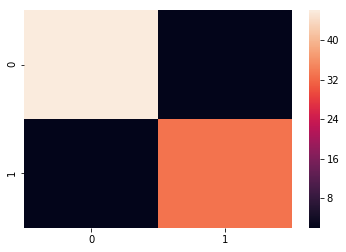

In [40]:
import seaborn as sns
%matplotlib inline

sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)))


In [43]:
prob = pipe.predict_proba(X_train)

In [45]:
prob

array([[2.44692405e-01, 7.55307595e-01],
       [9.99627873e-01, 3.72127261e-04],
       [9.94618367e-01, 5.38163267e-03],
       [4.95560308e-03, 9.95044397e-01],
       [4.77306419e-02, 9.52269358e-01],
       [2.11437089e-01, 7.88562911e-01],
       [3.54191748e-03, 9.96458083e-01],
       [9.99975953e-01, 2.40470554e-05],
       [9.70087369e-01, 2.99126313e-02],
       [7.28159161e-01, 2.71840839e-01],
       [1.57067110e-01, 8.42932890e-01],
       [6.88955815e-03, 9.93110442e-01],
       [9.89973612e-01, 1.00263878e-02],
       [9.99999880e-01, 1.20161182e-07],
       [9.85961476e-01, 1.40385239e-02],
       [9.99987011e-01, 1.29893820e-05],
       [9.99985861e-01, 1.41394331e-05],
       [1.16431055e-03, 9.98835689e-01],
       [9.94221756e-01, 5.77824411e-03],
       [9.99434415e-01, 5.65584599e-04],
       [1.79007566e-02, 9.82099243e-01],
       [9.99990684e-01, 9.31591848e-06],
       [6.67493556e-02, 9.33250644e-01],
       [6.14506424e-03, 9.93854936e-01],
       [9.975331

In [47]:
prob[prob > 0.4]

array([0.75530759, 0.99962787, 0.99461837, 0.9950444 , 0.95226936,
       0.78856291, 0.99645808, 0.99997595, 0.97008737, 0.72815916,
       0.84293289, 0.99311044, 0.98997361, 0.99999988, 0.98596148,
       0.99998701, 0.99998586, 0.99883569, 0.99422176, 0.99943442,
       0.98209924, 0.99999068, 0.93325064, 0.99385494, 0.99753317,
       0.99997269, 0.87416912, 0.98798433, 0.9991275 , 0.4693    ,
       0.5307    , 0.9712973 , 0.9449867 , 0.99283986, 0.90900308,
       0.99764653, 0.92927794, 0.9805937 , 0.88932811, 0.99503363,
       0.99647258, 0.99138242, 0.99999984, 0.99974799, 0.999895  ,
       0.81236597, 0.99040432, 0.99606816, 0.96804307, 0.99945056,
       0.99686893, 0.93286257, 0.95931108, 0.72210008, 0.85001593,
       0.99729257, 0.71455101, 0.99999723, 0.99999798, 0.9973167 ,
       0.87885301, 0.90119089, 0.99648654, 0.99002045, 0.95783942,
       0.99997964, 0.6466401 , 0.47364749, 0.52635251, 0.99993156,
       0.9989609 , 0.65739301, 0.98767274, 0.99070956, 0.89516

/Users/richardmason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/Users/richardmason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


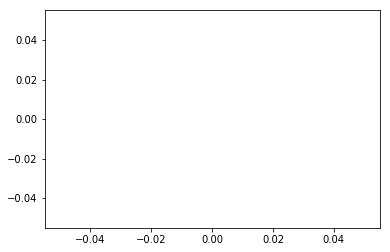

In [48]:
fpr=[]
tpr=[]
threshold=0.01
for i in range(10):
    clas=prob[:,1]>threshold
    frame=pd.DataFrame({'y_train':y_train,'predicted':clas})

    tp=frame[(frame['y_train']==1) & (frame['predicted']==True)].count()[0]
    tp

    tn=frame[(frame['y_train']==0) & (frame['predicted']==False)].count()[0]
    

    fp=frame[(frame['y_train']==0) & (frame['predicted']==True)].count()[0]
    fn=frame[(frame['y_train']==1) & (frame['predicted']==False)].count()[0]
    # print(tp,fp)
    # print(fn,tn)
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
    threshold+=0.01
plt.plot(fpr,tpr)


In [44]:
print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      0.97      0.93        35
          1       0.98      0.92      0.95        48

avg / total       0.94      0.94      0.94        83



### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

- in my model, all of the categorical features were zeroed out by lasso.  But saying, for example, if "rbc_normal" had a coefficient of 0.6, then having normal rbc's, or a 1 in this column, would increase the probability of having ckd by e^0.6

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: It is the best model for binary classification, and relatively simplistic because of it, which contributes to its popularity.  It's similarities to linear regression tend to make it intuitively understandable whereas many other advanced techniques are not so.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

## We should generate the confusion matrix on the test data, because that is the data we are trying to predict, and thus the data that it is useful to have such scores like precision, recall, and specificity on

In [45]:
len(X_test)

83

In [47]:
# y_preds = logreg.predict(X_test)
# confusion_matrix(y_test, y_preds)

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: In this case, it is important to maximize the recall, or sensitivity, since the cost of falsely telling someone they do have CKD, is far less than the potential cost of falsely telling someone they DO NOT have CKD, when they actually do(in which case we would have been maximizing the precision, or minimizing the false positive rate.)

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [ ]:
y.value_counts()

Answer:Yes, it's conceivable.  Since there are less than half as many cases of ckd than not-ckd, it makes the statistical analysis less reliable

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

In [ ]:
115/158

Answer: It can be a problem because our methods can achieve a high accuracy simply by predicting, for example, that every person does not have ckd, in which wwe will be right 115/158 or 73% of the time.  By predicting CKD instead of not-ckd, we will have a lower accuracy.  

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 3,600 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with about 4,000 observations, of which only 150 (3.75%) are non-CKD individuals.

In [54]:
df['class'].value_counts()

1    250
0    150
Name: class, dtype: int64

In [50]:
random.seed(42)
sample = df[df['class'] ==1].sample(n=3600, replace = True, random_state=42)

In [55]:
df_oversampled = pd.concat([df,sample])

In [56]:
df_oversampled

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,1,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,1,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1,0,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,1,0,0,0,0,0,0,0,0
5,60.0,90.0,1.015,3.0,0.0,74.0,25.0,1.1,142.0,3.2,...,0,0,0,0,1,1,0,0,1,0
6,68.0,70.0,1.010,0.0,0.0,100.0,54.0,24.0,104.0,4.0,...,0,1,0,0,0,0,0,0,0,0
7,24.0,NaN,1.015,2.0,4.0,410.0,31.0,1.1,NaN,NaN,...,1,0,0,0,0,1,0,0,1,0
8,52.0,100.0,1.015,3.0,0.0,138.0,60.0,1.9,NaN,NaN,...,1,0,1,0,1,1,0,0,0,1
9,53.0,90.0,1.020,2.0,0.0,70.0,107.0,7.2,114.0,3.7,...,0,0,1,0,1,1,0,1,0,1


In [ ]:
# import nltk

In [ ]:
# import nltk
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# lemmatizer.lemmatize("cats")


In [ ]:
# nltk.download()

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!